In [1]:
#
# --- The Definitive Colab Fix for Keras-OCR ---
#
# This cell installs a specific, older set of libraries that are known to be
# compatible with keras-ocr. This will downgrade many of Colab's default packages.
#
print("Installing a specific, older environment for Keras-OCR...")

# Step 1: Install a compatible version of NumPy first.
%pip install -q numpy==1.26.4

# Step 2: Install the core deep learning libraries with exact versions.
%pip install -q tensorflow-cpu==2.15.0 keras==2.15.0

# Step 3: Install keras-ocr itself.
%pip install -q keras-ocr==0.9.3

# Step 4: Install the other libraries for our project.
%pip install -q easyocr pytesseract Pillow opencv-python python-levenshtein pandas

print("\n✅ Installation complete.")
print("🔴 IMPORTANT: Please go to the 'Runtime' menu and select 'Restart runtime' now.")

Installing a specific, older environment for Keras-OCR...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

In [1]:
import os
import json
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # For progress bars

# Import OCR Tools
import easyocr
import keras_ocr
import pytesseract

# Import Evaluation Metric
from Levenshtein import ratio as levenshtein_ratio

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
from google.colab import drive

print("Connecting to Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive connected.")

Connecting to Google Drive...
Mounted at /content/drive
✅ Google Drive connected.


In [4]:
import os

# This path points to 'archive.zip' inside the 'colab_datasets' folder in your Drive.
# This should be correct based on our previous conversation.
drive_zip_path = '/content/drive/My Drive/colab_datasets/archive.zip'

# This is the folder where the data will be unzipped
dataset_dir = 'textocr_dataset'

print(f"Looking for file at: {drive_zip_path}")
if os.path.exists(drive_zip_path):
    print("✅ File found! Unzipping now... This will take a few minutes.")
    !unzip -q "{drive_zip_path}" -d {dataset_dir}
    print("\n✅ Unzipping complete! The dataset is ready for analysis.")
else:
    print(f"❌ ERROR: File not found at '{drive_zip_path}'. Please check the folder path and that 'archive.zip' is the correct filename.")

Looking for file at: /content/drive/My Drive/colab_datasets/archive.zip
✅ File found! Unzipping now... This will take a few minutes.

✅ Unzipping complete! The dataset is ready for analysis.


In [5]:
import json
import pandas as pd

# --- Configuration ---
SAMPLE_SIZE = 300
JSON_PATH = '/content/textocr_dataset/TextOCR_0.1_train.json'
IMAGE_DIR = '/content/textocr_dataset/train_val_images'

# --- Load the JSON file ---
print(f"Loading ground truth from: {JSON_PATH}")
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

# --- Parse the annotations ---
# CORRECTED: Use 'imgs' instead of 'images'
id_to_filename = {img['id']: img['file_name'] for img_id, img in data['imgs'].items()}

# CORRECTED: Use 'anns' instead of 'annotations'
annotations_by_img_id = {}
for ann_id, ann in data['anns'].items():
    img_id = ann['image_id']
    if img_id not in annotations_by_img_id:
        annotations_by_img_id[img_id] = []
    annotations_by_img_id[img_id].append(ann['utf8_string'])

# --- Create a DataFrame ---
print("Creating a DataFrame from the annotations...")
image_data = []
for img_id, texts in annotations_by_img_id.items():
    if img_id in id_to_filename:
        full_text = ' '.join(texts).strip()
        image_data.append({
            'file_name': id_to_filename[img_id],
            'ground_truth': full_text
        })
df = pd.DataFrame(image_data)

# --- Create our random sample ---
# We sample from the df DataFrame now
if len(df) >= SAMPLE_SIZE:
    sampled_df = df.sample(n=SAMPLE_SIZE, random_state=42)

Loading ground truth from: /content/textocr_dataset/TextOCR_0.1_train.json
Creating a DataFrame from the annotations...


In [6]:
# Run this in a new cell
try:
    print("Checking if the 'sampled_df' DataFrame was created...")
    # The display() function gives a nicer table output in Colab
    display(sampled_df.head())
    print(f"\n✅ Success! The DataFrame exists with {len(sampled_df)} rows.")
except NameError:
    print("\n❌ It seems the 'sampled_df' DataFrame was not created successfully.")
    print("This likely means the previous cell ran out of memory and crashed.")
    print("Please try going to the menu and selecting 'Runtime > Restart runtime' and then run the cells again from the beginning (mounting Drive, unzipping, etc.).")

Checking if the 'sampled_df' DataFrame was created...


,file_name,ground_truth
11063,train/3a7d196f293b0bf5.jpg,4-9% HATLIFTER STOUT GRAND RIDGE BREWERY VINTA...
18717,train/1940f68d6d697475.jpg,Ping Pin LEMON . -So So Pin . Pi S P . . . . .
5437,train/73db6439b8b9aa38.jpg,adidas . . das .
9767,train/01a28309568b4274.jpg,Chan ans 19 TOEWS KANE 88 88
17098,train/3b3fb77c202ef6eb.jpg,2ⁿᵈ Edition COMPUTER ALGORITHMS HOROWITZ SAHNI...



✅ Success! The DataFrame exists with 300 rows.


In [7]:
# Run this cell to initialize the OCR models
import easyocr
import keras_ocr

print("Initializing OCR models...")

# Initialize EasyOCR (using GPU)
print("Loading EasyOCR...")
easyocr_reader = easyocr.Reader(['en'], gpu=True)

# Initialize Keras-OCR
print("Loading Keras-OCR...")
keras_pipeline = keras_ocr.pipeline.Pipeline()

print("\n✅ All models initialized successfully!")

Initializing OCR models...
Loading EasyOCR...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteLoading Keras-OCR...
Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5

✅ All models initialized successfully!


In [8]:
# Import the tqdm library for the progress bar
from tqdm.auto import tqdm
import pytesseract
import cv2

results_list = []

# Use tqdm for a nice progress bar
for index, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Processing Images"):
    file_name = row['file_name']
    ground_truth = row['ground_truth']
    image_path = os.path.join(IMAGE_DIR, file_name)

    # Ensure image exists
    if not os.path.exists(image_path):
        continue

    # --- Run EasyOCR ---
    try:
        easy_result = easyocr_reader.readtext(image_path, detail=0, paragraph=True)
        easy_text = ' '.join(easy_result)
    except Exception as e:
        easy_text = f"Error: {e}"

    # --- Run Keras-OCR ---
    try:
        # Keras-OCR expects a list of images
        keras_images = [keras_ocr.tools.read(image_path)]
        keras_result = keras_pipeline.recognize(keras_images)
        # result is a list of lists, we take the first element for our single image
        keras_text = ' '.join([text for text, box in keras_result[0]])
    except Exception as e:
        keras_text = f"Error: {e}"


    # --- Run Pytesseract ---
    try:
        image_cv = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        pytess_text = pytesseract.image_to_string(image_rgb).strip()
    except Exception as e:
        pytess_text = f"Error: {e}"

    # --- Evaluate Accuracy ---
    easy_accuracy = levenshtein_ratio(ground_truth.lower(), easy_text.lower())
    keras_accuracy = levenshtein_ratio(ground_truth.lower(), keras_text.lower())
    pytess_accuracy = levenshtein_ratio(ground_truth.lower(), pytess_text.lower())

    # --- Store Results ---
    results_list.append({
        'file_name': file_name,
        'ground_truth': ground_truth,
        'easyocr_text': easy_text,
        'easyocr_accuracy': easy_accuracy,
        'keras_ocr_text': keras_text,
        'keras_ocr_accuracy': keras_accuracy,
        'pytesseract_text': pytess_text,
        'pytesseract_accuracy': pytess_accuracy,
    })

# Convert the list of results into a final DataFrame
results_df = pd.DataFrame(results_list)

print("\n✅ Analysis Complete!")

Processing Images:   0%|          | 0/300 [00:00<?, ?it/s]


✅ Analysis Complete!


In [10]:
import json
import pandas as pd
import os

# --- Configuration ---
SAMPLE_SIZE = 300
JSON_PATH = '/content/textocr_dataset/TextOCR_0.1_train.json'
# CORRECTED: This is the actual path to the folder containing the training images.
IMAGE_DIR = '/content/textocr_dataset/train_val_images/train_images/'

# --- Load the JSON file ---
print(f"Loading ground truth from: {JSON_PATH}")
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

# --- Parse the annotations ---
id_to_filename = {img['id']: img['file_name'] for img_id, img in data['imgs'].items()}
annotations_by_img_id = {}
for ann_id, ann in data['anns'].items():
    img_id = ann['image_id']
    if img_id not in annotations_by_img_id:
        annotations_by_img_id[img_id] = []
    annotations_by_img_id[img_id].append(ann['utf8_string'])

# --- Create a DataFrame ---
print("Creating a DataFrame from the annotations...")
image_data = []
for img_id, texts in annotations_by_img_id.items():
    if img_id in id_to_filename:
        full_text = ' '.join(texts).strip()
        # We will only store the base filename now, not the 'train/' prefix
        base_filename = os.path.basename(id_to_filename[img_id])
        image_data.append({
            'file_name': base_filename,
            'ground_truth': full_text
        })
df = pd.DataFrame(image_data)

# --- Create our random sample ---
if len(df) >= SAMPLE_SIZE:
    sampled_df = df.sample(n=SAMPLE_SIZE, random_state=42)
else:
    sampled_df = df

print(f"\nSuccessfully created a random sample of {len(sampled_df)} images.")
display(sampled_df.head())

Loading ground truth from: /content/textocr_dataset/TextOCR_0.1_train.json
Creating a DataFrame from the annotations...

Successfully created a random sample of 300 images.


,file_name,ground_truth
11063,3a7d196f293b0bf5.jpg,4-9% HATLIFTER STOUT GRAND RIDGE BREWERY VINTA...
18717,1940f68d6d697475.jpg,Ping Pin LEMON . -So So Pin . Pi S P . . . . .
5437,73db6439b8b9aa38.jpg,adidas . . das .
9767,01a28309568b4274.jpg,Chan ans 19 TOEWS KANE 88 88
17098,3b3fb77c202ef6eb.jpg,2ⁿᵈ Edition COMPUTER ALGORITHMS HOROWITZ SAHNI...


In [11]:
import easyocr
import keras_ocr
import pytesseract
import os
from Levenshtein import ratio as levenshtein_ratio

print("Initializing OCR models...")

# Initialize EasyOCR (using GPU)
print("Loading EasyOCR...")
easyocr_reader = easyocr.Reader(['en'], gpu=True)

# Initialize Keras-OCR
print("Loading Keras-OCR...")
keras_pipeline = keras_ocr.pipeline.Pipeline()

print("\n✅ All models initialized successfully!")

Initializing OCR models...
Loading EasyOCR...
Loading Keras-OCR...
Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5

✅ All models initialized successfully!


In [12]:
from tqdm.auto import tqdm
import cv2
import pytesseract
from Levenshtein import ratio as levenshtein_ratio

results_list = []

# Loop through the 300 samples with a progress bar
for index, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Processing Images"):
    file_name = row['file_name'] # This is now just the base filename, e.g., 'image.jpg'
    ground_truth = row['ground_truth']
    # CORRECTED: This now builds the full, correct path to the image
    image_path = os.path.join(IMAGE_DIR, file_name)

    # Ensure image exists before trying to process
    if not os.path.exists(image_path):
        print(f"Warning: Could not find image {image_path}. Skipping.")
        continue

    # --- Run EasyOCR ---
    try:
        easy_result = easyocr_reader.readtext(image_path, detail=0, paragraph=True)
        easy_text = ' '.join(easy_result)
    except Exception as e:
        easy_text = f"Error: {e}"

    # --- Run Keras-OCR ---
    try:
        keras_images = [keras_ocr.tools.read(image_path)]
        keras_result = keras_pipeline.recognize(keras_images)
        keras_text = ' '.join([text for text, box in keras_result[0]])
    except Exception as e:
        keras_text = f"Error: {e}"

    # --- Run Pytesseract ---
    try:
        image_cv = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        pytess_text = pytesseract.image_to_string(image_rgb).strip()
    except Exception as e:
        pytess_text = f"Error: {e}"

    # --- Evaluate Accuracy ---
    easy_accuracy = levenshtein_ratio(ground_truth.lower(), easy_text.lower())
    keras_accuracy = levenshtein_ratio(ground_truth.lower(), keras_text.lower())
    pytess_accuracy = levenshtein_ratio(ground_truth.lower(), pytess_text.lower())

    # --- Store Results for this image ---
    results_list.append({
        'file_name': file_name,
        'ground_truth': ground_truth,
        'easyocr_text': easy_text,
        'easyocr_accuracy': easy_accuracy,
        'keras_ocr_text': keras_text,
        'keras_ocr_accuracy': keras_accuracy,
        'pytesseract_text': pytess_text,
        'pytesseract_accuracy': pytess_accuracy,
    })

# Convert the list of results into a final DataFrame
results_df = pd.DataFrame(results_list)

print("\n✅ Analysis Complete!")

Processing Images:   0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step

✅ Analysis Complete!


In [13]:
import pandas as pd

# --- Display a preview of the detailed results ---
print("--- Results Preview ---")
# Set a pandas option to display more text from each column for better viewing
pd.set_option('display.max_colwidth', 80)
display(results_df.head())


# --- Calculate and Display Average Accuracies ---
print("\n--- Average Model Accuracy ---")
# Calculate the mean of the accuracy columns and multiply by 100 for percentage
avg_easy_acc = results_df['easyocr_accuracy'].mean() * 100
avg_keras_acc = results_df['keras_ocr_accuracy'].mean() * 100
avg_pytess_acc = results_df['pytesseract_accuracy'].mean() * 100

print(f"EasyOCR Average Accuracy:     {avg_easy_acc:.2f}%")
print(f"Keras-OCR Average Accuracy:   {avg_keras_acc:.2f}%")
print(f"Pytesseract Average Accuracy: {avg_pytess_acc:.2f}%")


# --- Save the full, detailed results to a CSV file ---
results_df.to_csv('ocr_comparison_results.csv', index=False)
print("\nFull detailed results have been saved to 'ocr_comparison_results.csv'")
print("You can download this file from the file browser on the left sidebar.")

--- Results Preview ---


,file_name,ground_truth,easyocr_text,easyocr_accuracy,keras_ocr_text,keras_ocr_accuracy,pytesseract_text,pytesseract_accuracy
0,3a7d196f293b0bf5.jpg,4-9% HATLIFTER STOUT GRAND RIDGE BREWERY VINTAGED NO ADDED CHEMICALS OR PRES...,"(ewer ~u5 Most AWARDED 'BREWERY 49"" euryA GRAND 9 9 .ko Rewe?) 6 Aunt Aobrd...",0.361775,crans ridge srewer brewery o most awarded wolift g crand ridge ppewev wo tre...,0.412698,,0.000000
1,1940f68d6d697475.jpg,Ping Pin LEMON . -So So Pin . Pi S P . . . . .,LEd Pin PvSe Ord ES,0.338462,dv lemol so p s din,0.400000,,0.000000
2,73db6439b8b9aa38.jpg,adidas . . das .,0S odlaas,0.400000,css caigas,0.307692,,0.000000
3,01a28309568b4274.jpg,Chan ans 19 TOEWS KANE 88 88,TOEwS 19 8 KINE Ohay|,0.408163,toews 19 o kane cha ans,0.509804,,0.000000
4,3b3fb77c202ef6eb.jpg,2ⁿᵈ Edition COMPUTER ALGORITHMS HOROWITZ SAHNI RAJASEKERAN SP AN INTRODUCTIO...,A LGOR T5 COMPUTER Edition ALGORITHMS COvPUTERS AND InTRACTABILITY Guda Kotn...,0.481481,algorts 2nn edition computer computers and intractability guce witing lo ino...,0.466312,CompurTerR\nALGORITHMS\n\nHorowmz + Sauni\nRAJASEKERAN\n\nTrogramming\n\n¥\n...,0.324519



--- Average Model Accuracy ---
EasyOCR Average Accuracy:     45.47%
Keras-OCR Average Accuracy:   47.56%
Pytesseract Average Accuracy: 10.10%

Full detailed results have been saved to 'ocr_comparison_results.csv'
You can download this file from the file browser on the left sidebar.


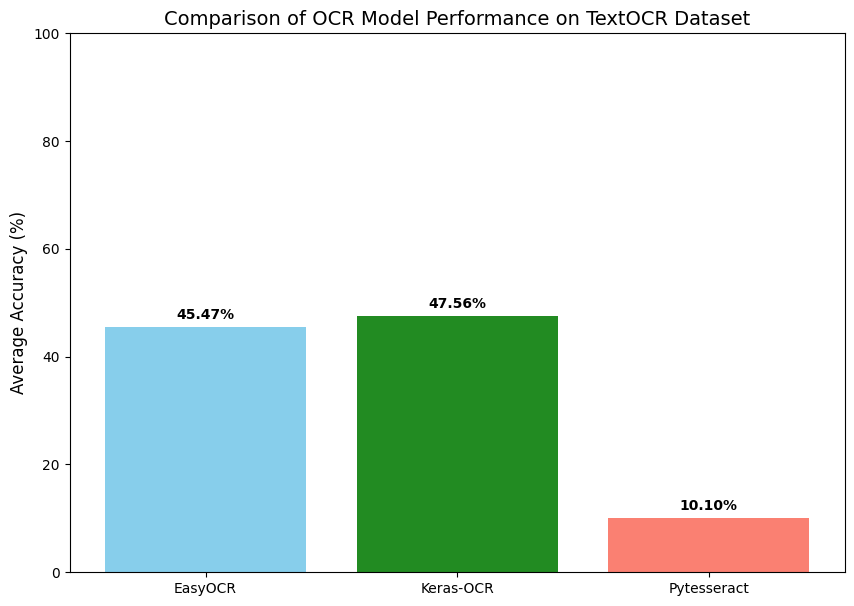

In [14]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['EasyOCR', 'Keras-OCR', 'Pytesseract']

accuracies = [
    results_df['easyocr_accuracy'].mean() * 100,
    results_df['keras_ocr_accuracy'].mean() * 100,
    results_df['pytesseract_accuracy'].mean() * 100
]

plt.figure(figsize=(10, 7))

bars = plt.bar(model_names, accuracies, color=['skyblue', 'forestgreen', 'salmon'])

plt.ylabel('Average Accuracy (%)', fontsize=12)
plt.title('Comparison of OCR Model Performance on TextOCR Dataset', fontsize=14)
plt.ylim(0, 100) # Set the y-axis to go from 0 to 100%


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontweight='bold')

# Display the chart
plt.show()

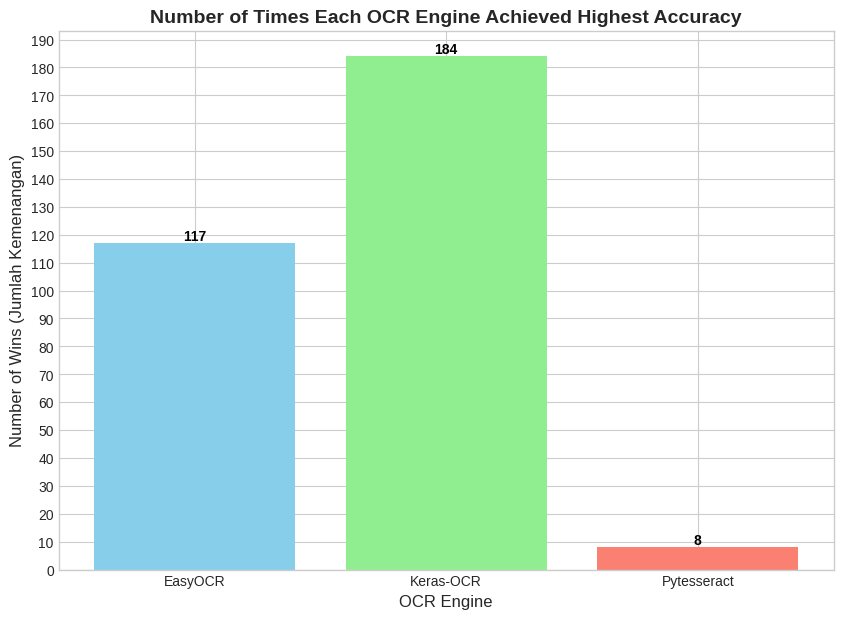

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

if 'results_df' not in locals():
    print("DataFrame 'results_df' tidak ditemukan. Silakan jalankan sel analisis terlebih dahulu.")
else:
    # 1. Menghitung berapa kali setiap engine menang
    win_counts = {
        'EasyOCR': 0,
        'Keras-OCR': 0,
        'Pytesseract': 0
    }
    for index, row in results_df.iterrows():
        accuracies = {
            'EasyOCR': row['easyocr_accuracy'],
            'Keras-OCR': row['keras_ocr_accuracy'],
            'Pytesseract': row['pytesseract_accuracy']
        }
        if max(accuracies.values()) > 0:
            max_accuracy = max(accuracies.values())
            for engine, acc in accuracies.items():
                if acc == max_accuracy:
                    win_counts[engine] += 1

    # 2. Membuat grafik batang dari hasil hitungan
    engines = list(win_counts.keys())
    counts = list(win_counts.values())

    plt.figure(figsize=(10, 7))
    bars = plt.bar(engines, counts, color=['skyblue', 'lightgreen', 'salmon'])

    # Menambahkan judul dan label
    plt.title('Number of Times Each OCR Engine Achieved Highest Accuracy', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Wins (Jumlah Kemenangan)', fontsize=12)
    plt.xlabel('OCR Engine', fontsize=12)

    if all(isinstance(c, int) for c in counts) and max(counts) > 0:
        plt.yticks(range(0, max(counts) + 10, 10)) # Mengatur skala sumbu Y

    # Menambahkan label angka di atas setiap batang
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom', fontweight='bold', color='black')

    plt.show()

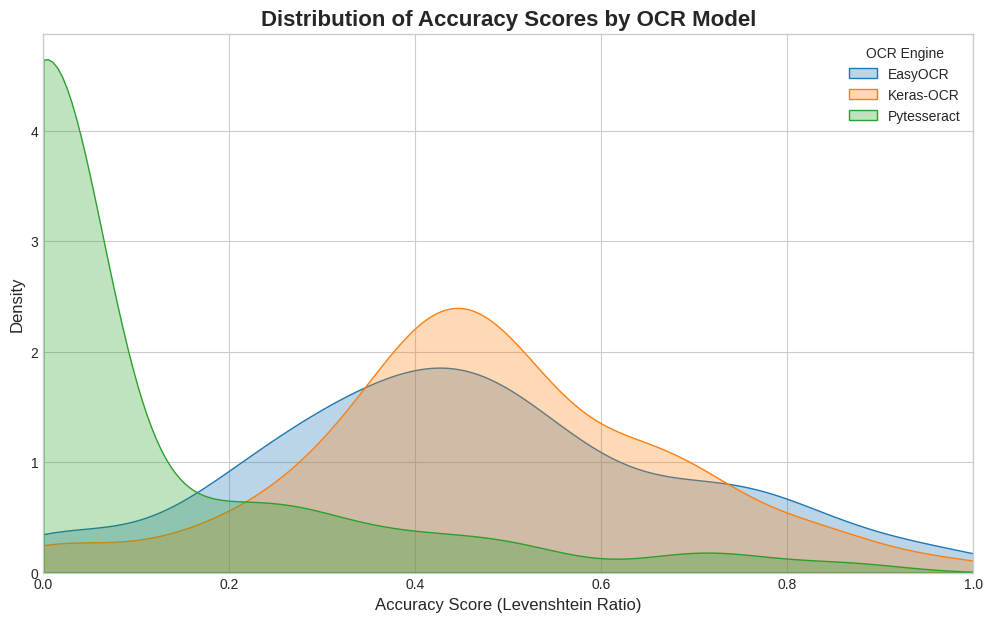

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Kode ini akan memeriksa apakah 'results_df' sudah ada
if 'results_df' not in locals():
    print("DataFrame 'results_df' tidak ditemukan. Pastikan Anda telah menjalankan sel analisis yang memproses gambar terlebih dahulu.")
else:
    # Mengatur style dan ukuran plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    # Membuat KDE plot untuk distribusi akurasi setiap model
    sns.kdeplot(data=results_df['easyocr_accuracy'], label='EasyOCR', fill=True, alpha=0.3, clip=(0, 1))
    sns.kdeplot(data=results_df['keras_ocr_accuracy'], label='Keras-OCR', fill=True, alpha=0.3, clip=(0, 1))
    sns.kdeplot(data=results_df['pytesseract_accuracy'], label='Pytesseract', fill=True, alpha=0.3, clip=(0, 1))

    # Menambahkan judul, label, dan legenda
    plt.title('Distribution of Accuracy Scores by OCR Model', fontsize=16, fontweight='bold')
    plt.xlabel('Accuracy Score (Levenshtein Ratio)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='OCR Engine')
    plt.xlim(0, 1) # Membatasi sumbu-x dari 0 hingga 1

    # Menampilkan plot
    plt.show()